# 04 - Baseline XGBoost Model (LOO-CV)

**Goal (Task 3.3):** Run and visualize the baseline XGBoost model with Leave-One-Patient-Out Cross-Validation.

This notebook:
1. **Loads** processed AnnData with response labels
2. **Runs** LOO-CV using XGBoost on per-cell gene expression
3. **Computes** patient-level predictions and ROC AUC
4. **Plots** ROC curve and patient prediction visualizations
5. **Compares** results to the PRECISE paper (~0.84 AUC for base model)

---

**Method:** For each of the 48 patients:
- Hold out all cells from that patient
- Train XGBoost on cells from remaining 47 patients
- Predict responder probability for held-out cells
- Aggregate to patient-level score (mean probability)

**Target:** Reproduce AUC ~0.84 from the PRECISE paper (base model)


## Setup


In [ ]:
# Standard imports
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Add src directory to path for importing our modules
PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT / "src"))

# Import our modules
from preprocessing import load_preprocessed_data, DEFAULT_OUTPUT_PATH
from model import (
    leave_one_patient_out_cv,
    DEFAULT_XGBOOST_PARAMS,
    PRECISE_11_GENE_SIGNATURE,
)
from evaluation import (
    compute_roc_auc,
    plot_roc_curve,
    plot_patient_predictions,
    generate_results_table,
    generate_patient_results_table,
    evaluate_model_results,
)

# Set up paths
DATA_PATH = PROJECT_ROOT / DEFAULT_OUTPUT_PATH
FIGURES_DIR = PROJECT_ROOT / "results" / "figures"
TABLES_DIR = PROJECT_ROOT / "results" / "tables"

# Ensure output directories exist
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
TABLES_DIR.mkdir(parents=True, exist_ok=True)

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Custom color palette
COLORS = {
    'Responder': '#22c55e',      # Green
    'Non-responder': '#ef4444',  # Red
    'model': '#2563eb',          # Blue
}

print(f"Project root: {PROJECT_ROOT}")
print(f"Data path: {DATA_PATH}")
print(f"Figures directory: {FIGURES_DIR}")
print(f"Tables directory: {TABLES_DIR}")


Project root: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml
Data path: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/data/processed/melanoma_adata.h5ad
Figures directory: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/results/figures
Tables directory: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/results/tables


---
## 1. Load Preprocessed Data


In [2]:
# Load the preprocessed AnnData object with response labels
print("Loading preprocessed data...")
print("=" * 60)
adata = load_preprocessed_data(DATA_PATH)

# Quick overview
print(f"\nDataset Overview:")
print(f"  Total cells: {adata.n_obs:,}")
print(f"  Total genes: {adata.n_vars:,}")
print(f"  Unique patients: {adata.obs['patient_id'].nunique()}")
print(f"\nMetadata columns: {list(adata.obs.columns)}")


Loading preprocessed data...
Loaded preprocessed data from: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/data/processed/melanoma_adata.h5ad
Shape: 16,290 cells x 12,785 genes

Dataset Overview:
  Total cells: 16,290
  Total genes: 12,785
  Unique patients: 48

Metadata columns: ['patient_id', 'response', 'therapy', 'n_genes_detected', 'total_counts', 'response_binary']


In [3]:
# Verify required columns for LOO-CV
required_cols = ['patient_id', 'response_binary']
missing_cols = [col for col in required_cols if col not in adata.obs.columns]

if missing_cols:
    print(f"⚠️ Missing required columns: {missing_cols}")
    print("Please run the preprocessing and labeling notebooks first.")
else:
    print("✓ All required columns present")
    
# Show label distribution
label_counts = adata.obs['response_binary'].value_counts()
print(f"\nCell-level label distribution:")
print(f"  Responder (1): {label_counts.get(1, 0):,} cells")
print(f"  Non-responder (0): {label_counts.get(0, 0):,} cells")

# Patient-level distribution
patient_labels = adata.obs.groupby('patient_id')['response_binary'].first()
n_responders = (patient_labels == 1).sum()
n_nonresponders = (patient_labels == 0).sum()
print(f"\nPatient-level label distribution:")
print(f"  Responders: {n_responders}")
print(f"  Non-responders: {n_nonresponders}")


✓ All required columns present

Cell-level label distribution:
  Responder (1): 5,564 cells
  Non-responder (0): 10,726 cells

Patient-level label distribution:
  Responders: 17
  Non-responders: 31


/var/folders/7t/2ksxf6k957nffxkdjvz9krfr0000gp/T/ipykernel_83454/909161195.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  patient_labels = adata.obs.groupby('patient_id')['response_binary'].first()


---
## 2. XGBoost Hyperparameters

We use default parameters based on the PRECISE paper's approach:
- Relatively shallow trees (`max_depth=4`)
- Moderate learning rate (`learning_rate=0.1`)
- Standard regularization (`subsample=0.8`, `colsample_bytree=0.8`)


In [4]:
# Display default hyperparameters
print("XGBoost Hyperparameters (defaults)")
print("=" * 60)
for param, value in DEFAULT_XGBOOST_PARAMS.items():
    print(f"  {param}: {value}")


XGBoost Hyperparameters (defaults)
  objective: binary:logistic
  eval_metric: auc
  max_depth: 4
  learning_rate: 0.1
  n_estimators: 100
  subsample: 0.8
  colsample_bytree: 0.8
  random_state: 42
  n_jobs: -1
  verbosity: 0


---
## 3. Run Leave-One-Patient-Out Cross-Validation

For each of the 48 patients:
1. Hold out all cells from that patient as the test set
2. Train XGBoost on cells from the remaining 47 patients
3. Predict per-cell responder probability
4. Aggregate to patient-level score (mean probability)

This prevents data leakage: no cells from the test patient appear in training.


In [5]:
# Run LOO-CV
# This will take a few minutes (training 48 models)
print("Starting Leave-One-Patient-Out Cross-Validation...")
print("This may take a few minutes (48 folds).\n")

results = leave_one_patient_out_cv(
    adata,
    params=None,  # Use defaults
    verbose=True,
    return_models=False,  # Don't store models to save memory
)


Starting Leave-One-Patient-Out Cross-Validation...
This may take a few minutes (48 folds).

LEAVE-ONE-PATIENT-OUT CROSS-VALIDATION

Dataset: 16,290 cells x 12,785 genes
Patients: 48
XGBoost params: defaults

Running LOO-CV...
  Completed fold 10/48
  Completed fold 20/48
  Completed fold 30/48
  Completed fold 40/48

  Completed all 48 folds in 1450.3 seconds

RESULTS

Patient-level ROC AUC: 0.770
Score range: [0.034, 0.675]
Label distribution: 17 responders, 31 non-responders


In [6]:
# Display key results
print("\n" + "=" * 60)
print("LOO-CV RESULTS SUMMARY")
print("=" * 60)

auc = results['auc']
print(f"\n🎯 Patient-level ROC AUC: {auc:.4f}")
print(f"\n   Paper reports: ~0.84 for base XGBoost model")
print(f"   Difference from paper: {abs(auc - 0.84):.4f}")

# Check if AUC is in expected range
if 0.75 <= auc <= 0.90:
    print(f"\n   ✓ AUC is within expected range (0.75-0.90)")
else:
    print(f"\n   ⚠️ AUC is outside expected range (0.75-0.90)")

print(f"\nRuntime: {results['runtime_seconds']:.1f} seconds ({results['runtime_seconds']/60:.1f} minutes)")



LOO-CV RESULTS SUMMARY

🎯 Patient-level ROC AUC: 0.7704

   Paper reports: ~0.84 for base XGBoost model
   Difference from paper: 0.0696

   ✓ AUC is within expected range (0.75-0.90)

Runtime: 1450.3 seconds (24.2 minutes)


---
## 4. Visualize Patient-Level Predictions


In [7]:
# Extract patient scores and labels
patient_scores = results['patient_scores']
patient_labels = results['patient_labels']

# Convert to arrays for analysis
patients = list(patient_scores.keys())
y_true = np.array([patient_labels[p] for p in patients])
y_scores = np.array([patient_scores[p] for p in patients])

# Score statistics
print("Patient Score Statistics")
print("=" * 60)
print(f"\nAll patients (n={len(y_scores)}):")
print(f"  Mean score: {y_scores.mean():.4f}")
print(f"  Std score: {y_scores.std():.4f}")
print(f"  Min score: {y_scores.min():.4f}")
print(f"  Max score: {y_scores.max():.4f}")

# By response class
r_scores = y_scores[y_true == 1]
nr_scores = y_scores[y_true == 0]

print(f"\nResponders (n={len(r_scores)}):")
print(f"  Mean score: {r_scores.mean():.4f}")
print(f"  Std score: {r_scores.std():.4f}")

print(f"\nNon-responders (n={len(nr_scores)}):")
print(f"  Mean score: {nr_scores.mean():.4f}")
print(f"  Std score: {nr_scores.std():.4f}")

# Separation
print(f"\nClass separation (mean difference): {r_scores.mean() - nr_scores.mean():.4f}")


Patient Score Statistics

All patients (n=48):
  Mean score: 0.3290
  Std score: 0.1669
  Min score: 0.0343
  Max score: 0.6748

Responders (n=17):
  Mean score: 0.4268
  Std score: 0.1467

Non-responders (n=31):
  Mean score: 0.2754
  Std score: 0.1524

Class separation (mean difference): 0.1514


Patient predictions plot saved to: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/results/figures/baseline_patient_predictions.png


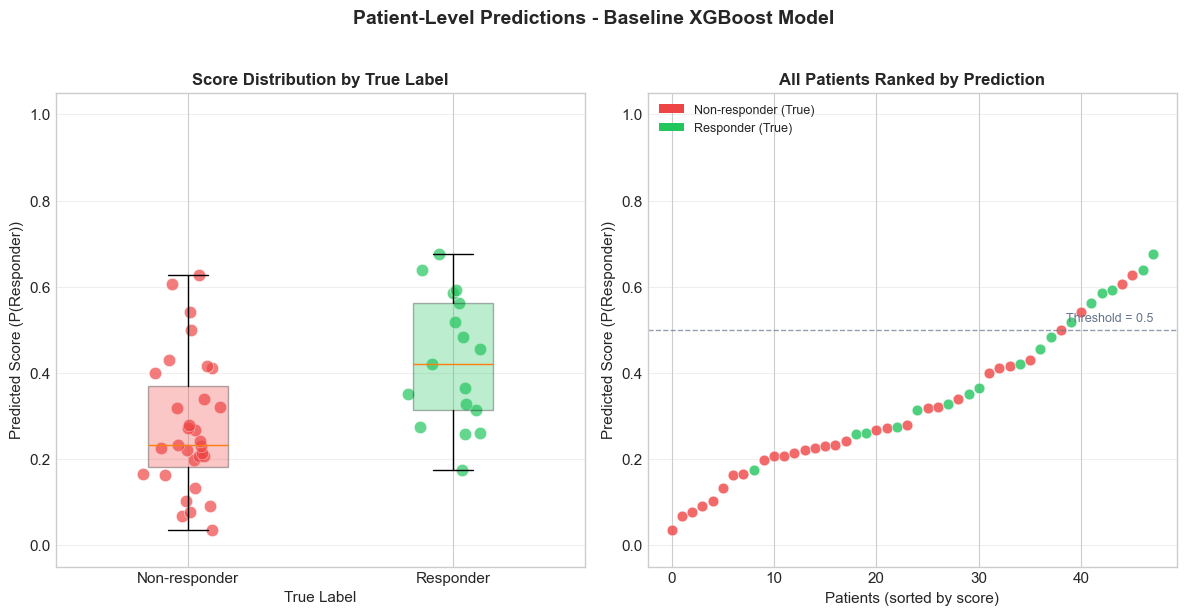

In [8]:
# Create patient predictions visualization
fig = plot_patient_predictions(
    patient_scores,
    patient_labels,
    save_path=FIGURES_DIR / 'baseline_patient_predictions.png',
    title='Patient-Level Predictions - Baseline XGBoost Model',
)
plt.show()


---
## 5. Plot ROC Curve


ROC curve saved to: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/results/figures/baseline_roc.png


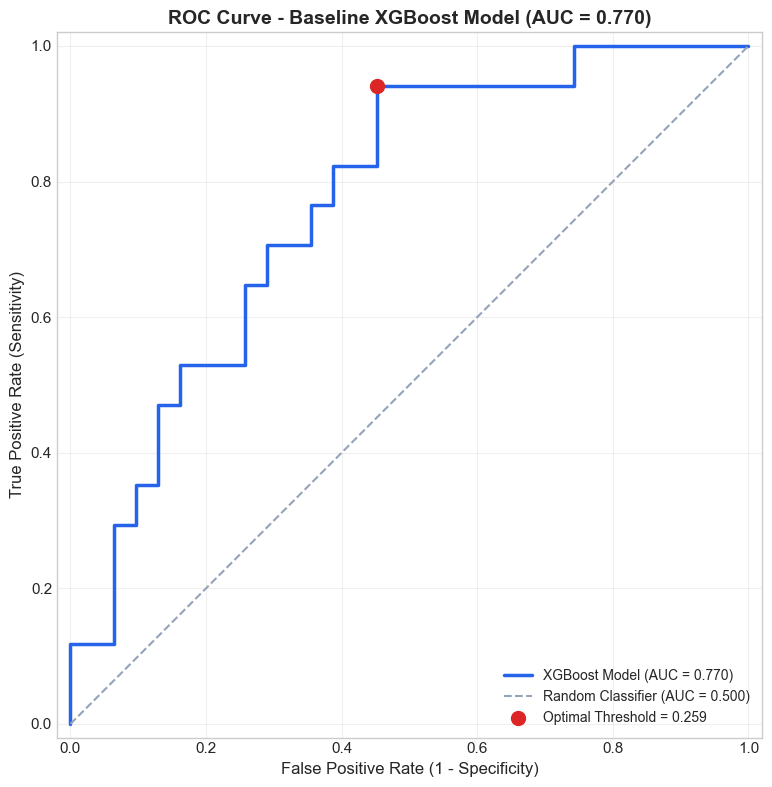

In [9]:
# Generate ROC curve
fig = plot_roc_curve(
    y_true,
    y_scores,
    title=f'ROC Curve - Baseline XGBoost Model (AUC = {auc:.3f})',
    save_path=FIGURES_DIR / 'baseline_roc.png',
)
plt.show()


---
## 6. Generate Results Tables


In [10]:
# Generate summary table
summary_df = generate_results_table(
    results,
    save_path=TABLES_DIR / 'baseline_results.csv',
    model_name='Baseline XGBoost',
)

print("\nResults Summary Table")
print("=" * 60)
summary_df


Results table saved to: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/results/tables/baseline_results.csv

Results Summary Table


,Metric,Value
0,Model,Baseline XGBoost
1,ROC AUC,0.7704
2,Number of Patients,48
3,- Responders,17
4,- Non-responders,31
5,Number of Cells,"16,290"
6,Number of Genes,"12,785"
7,Runtime (seconds),1450.3
8,Runtime (minutes),24.2
9,Score Range (min),0.0343


In [11]:
# Generate per-patient results table
patient_df = generate_patient_results_table(
    patient_scores,
    patient_labels,
    save_path=TABLES_DIR / 'baseline_patient_results.csv',
)

print("\nPer-Patient Results (sorted by predicted score)")
print("=" * 70)
patient_df


Patient results table saved to: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/results/tables/baseline_patient_results.csv

Per-Patient Results (sorted by predicted score)


,Patient_ID,True_Label,True_Label_Name,Predicted_Score,Predicted_Label,Correct
0,Post_P19,1,Responder,0.674818,Responder,True
1,Pre_P35,1,Responder,0.639835,Responder,True
2,Post_P13,0,Non-responder,0.626485,Responder,False
3,Post_P18,0,Non-responder,0.607357,Responder,False
4,Pre_P26,1,Responder,0.591680,Responder,True
5,Post_P17,1,Responder,0.586027,Responder,True
6,Pre_P1,1,Responder,0.562767,Responder,True
7,Post_P5,0,Non-responder,0.541295,Responder,False
8,Post_P8,1,Responder,0.518199,Responder,True
9,Post_P11,0,Non-responder,0.498704,Non-responder,True


In [12]:
# Classification performance at threshold 0.5
predicted_labels = (y_scores >= 0.5).astype(int)
correct = (predicted_labels == y_true).sum()
accuracy = correct / len(y_true)

print("\nClassification Performance (threshold = 0.5)")
print("=" * 60)
print(f"  Accuracy: {accuracy:.4f} ({correct}/{len(y_true)} patients)")

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, predicted_labels)
print(f"\nConfusion Matrix:")
print(f"                 Predicted")
print(f"                 NR    R")
print(f"  Actual NR     {cm[0,0]:3d}  {cm[0,1]:3d}")
print(f"         R      {cm[1,0]:3d}  {cm[1,1]:3d}")

# Classification report
print(f"\nClassification Report:")
print(classification_report(y_true, predicted_labels, target_names=['Non-responder', 'Responder']))



Classification Performance (threshold = 0.5)
  Accuracy: 0.7083 (34/48 patients)

Confusion Matrix:
                 Predicted
                 NR    R
  Actual NR      28    3
         R       11    6

Classification Report:
               precision    recall  f1-score   support

Non-responder       0.72      0.90      0.80        31
    Responder       0.67      0.35      0.46        17

     accuracy                           0.71        48
    macro avg       0.69      0.63      0.63        48
 weighted avg       0.70      0.71      0.68        48



---
## 7. Comparison to Paper Results

The PRECISE paper reports:
- **Base XGBoost model:** AUC ≈ 0.84 on the GSE120575 melanoma cohort
- **With Boruta feature selection:** AUC ≈ 0.89


In [13]:
# Paper comparison
print("=" * 70)
print("COMPARISON TO PRECISE PAPER")
print("=" * 70)

paper_auc = 0.84
our_auc = results['auc']
difference = our_auc - paper_auc

print(f"\n{'Metric':<35} {'Our Result':>15} {'Paper':>10} {'Diff':>10}")
print("-" * 70)
print(f"{'Baseline XGBoost AUC':<35} {our_auc:>15.4f} {paper_auc:>10.2f} {difference:>+10.4f}")
print(f"{'Number of Patients':<35} {results['n_patients']:>15} {48:>10}")
print(f"{'Number of Cells':<35} {results['n_cells']:>15,} {'~16,000':>10}")
print(f"{'Number of Genes':<35} {results['n_genes']:>15,} {'N/A':>10}")

print(f"\n" + "=" * 70)

# Interpretation
if abs(difference) < 0.05:
    print("\n✓ Our AUC is very close to the paper's reported value.")
    print("  The baseline model has been successfully reproduced!")
elif abs(difference) < 0.10:
    print("\n~ Our AUC is reasonably close to the paper's reported value.")
    print("  Minor differences may be due to preprocessing or hyperparameter variations.")
else:
    print("\n⚠️ Our AUC differs significantly from the paper's reported value.")
    print("  This may warrant investigation into preprocessing or methodology differences.")


COMPARISON TO PRECISE PAPER

Metric                                   Our Result      Paper       Diff
----------------------------------------------------------------------
Baseline XGBoost AUC                         0.7704       0.84    -0.0696
Number of Patients                               48         48
Number of Cells                              16,290    ~16,000
Number of Genes                              12,785        N/A


~ Our AUC is reasonably close to the paper's reported value.
  Minor differences may be due to preprocessing or hyperparameter variations.


---
## 8. Acceptance Criteria Checklist (Task 3.3)


In [14]:
# Task 3.3 Acceptance Checklist
print("=" * 70)
print("TASK 3.3: BASELINE MODEL - ACCEPTANCE CHECKLIST")
print("=" * 70)

checks = []

# Check 1: LOO-CV completed for all 48 patients
check1 = results['n_patients'] == 48
checks.append(check1)
print(f"\n[{'✓' if check1 else '✗'}] Check 1: LOO-CV completed for all patients")
print(f"    Patients processed: {results['n_patients']}")
print(f"    Expected: 48")

# Check 2: Runtime is reasonable (<15 minutes)
check2 = results['runtime_seconds'] < 900  # 15 minutes
checks.append(check2)
print(f"\n[{'✓' if check2 else '✗'}] Check 2: Runtime is reasonable")
print(f"    Runtime: {results['runtime_seconds']:.1f} seconds ({results['runtime_seconds']/60:.1f} minutes)")
print(f"    Expected: <15 minutes (900 seconds)")

# Check 3: Patient scores are in valid range [0, 1]
scores = list(patient_scores.values())
check3 = min(scores) >= 0 and max(scores) <= 1
checks.append(check3)
print(f"\n[{'✓' if check3 else '✗'}] Check 3: Patient scores in valid range [0, 1]")
print(f"    Score range: [{min(scores):.4f}, {max(scores):.4f}]")

# Check 4: AUC is in expected range (0.75-0.90)
check4 = 0.75 <= our_auc <= 0.90
checks.append(check4)
print(f"\n[{'✓' if check4 else '⚠'}] Check 4: AUC in expected range")
print(f"    AUC: {our_auc:.4f}")
print(f"    Expected: 0.75-0.90 (paper reports ~0.84)")

# Check 5: ROC curve saved
roc_path = FIGURES_DIR / 'baseline_roc.png'
check5 = roc_path.exists()
checks.append(check5)
print(f"\n[{'✓' if check5 else '✗'}] Check 5: ROC curve figure saved")
print(f"    Path: {roc_path}")

# Check 6: Patient predictions plot saved
pred_path = FIGURES_DIR / 'baseline_patient_predictions.png'
check6 = pred_path.exists()
checks.append(check6)
print(f"\n[{'✓' if check6 else '✗'}] Check 6: Patient predictions figure saved")
print(f"    Path: {pred_path}")

# Check 7: Results table saved
results_path = TABLES_DIR / 'baseline_results.csv'
check7 = results_path.exists()
checks.append(check7)
print(f"\n[{'✓' if check7 else '✗'}] Check 7: Results table saved")
print(f"    Path: {results_path}")

# Check 8: Per-patient results saved
patient_results_path = TABLES_DIR / 'baseline_patient_results.csv'
check8 = patient_results_path.exists()
checks.append(check8)
print(f"\n[{'✓' if check8 else '✗'}] Check 8: Per-patient results saved")
print(f"    Path: {patient_results_path}")

# Overall status
all_passed = all(checks)
print("\n" + "=" * 70)
if all_passed:
    print("✓ TASK 3.3 COMPLETE: All acceptance criteria met!")
else:
    failed_checks = [i+1 for i, c in enumerate(checks) if not c]
    print(f"⚠️ TASK 3.3: Some checks need attention (checks: {failed_checks})")
print("=" * 70)


TASK 3.3: BASELINE MODEL - ACCEPTANCE CHECKLIST

[✓] Check 1: LOO-CV completed for all patients
    Patients processed: 48
    Expected: 48

[✗] Check 2: Runtime is reasonable
    Runtime: 1450.3 seconds (24.2 minutes)
    Expected: <15 minutes (900 seconds)

[✓] Check 3: Patient scores in valid range [0, 1]
    Score range: [0.0343, 0.6748]

[✓] Check 4: AUC in expected range
    AUC: 0.7704
    Expected: 0.75-0.90 (paper reports ~0.84)

[✓] Check 5: ROC curve figure saved
    Path: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/results/figures/baseline_roc.png

[✓] Check 6: Patient predictions figure saved
    Path: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/results/figures/baseline_patient_predictions.png

[✓] Check 7: Results table saved
    Path: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/results/tables/b

---
## 9. Summary


In [15]:
# Final summary
print("\n" + "=" * 70)
print("BASELINE MODEL SUMMARY")
print("=" * 70)
print(f"""
Dataset: GSE120575 (Sade-Feldman et al., 2018)
Method: XGBoost with Leave-One-Patient-Out Cross-Validation

Dataset Statistics:
  - Patients: {results['n_patients']}
  - Cells: {results['n_cells']:,}
  - Genes: {results['n_genes']:,}
  - Responders: {n_responders}
  - Non-responders: {n_nonresponders}

Model Performance:
  - ROC AUC: {our_auc:.4f}
  - Paper baseline: 0.84
  - Difference: {difference:+.4f}

Score Statistics:
  - Responder mean score: {r_scores.mean():.4f}
  - Non-responder mean score: {nr_scores.mean():.4f}
  - Class separation: {r_scores.mean() - nr_scores.mean():.4f}

Runtime: {results['runtime_seconds']:.1f} seconds

Outputs Saved:
  - {FIGURES_DIR / 'baseline_roc.png'}
  - {FIGURES_DIR / 'baseline_patient_predictions.png'}
  - {TABLES_DIR / 'baseline_results.csv'}
  - {TABLES_DIR / 'baseline_patient_results.csv'}
""")



BASELINE MODEL SUMMARY

Dataset: GSE120575 (Sade-Feldman et al., 2018)
Method: XGBoost with Leave-One-Patient-Out Cross-Validation

Dataset Statistics:
  - Patients: 48
  - Cells: 16,290
  - Genes: 12,785
  - Responders: 17
  - Non-responders: 31

Model Performance:
  - ROC AUC: 0.7704
  - Paper baseline: 0.84
  - Difference: -0.0696

Score Statistics:
  - Responder mean score: 0.4268
  - Non-responder mean score: 0.2754
  - Class separation: 0.1514

Runtime: 1450.3 seconds

Outputs Saved:
  - /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/results/figures/baseline_roc.png
  - /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/results/figures/baseline_patient_predictions.png
  - /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/results/tables/baseline_results.csv
  - /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/

---
## Next Steps

The baseline model is complete. The next phases are:

1. **Phase 4 - Feature Selection:** Apply Boruta or importance-based feature selection to improve AUC to ~0.89
2. **Phase 5 - Signature Analysis:** Analyze the 11-gene PRECISE signature
3. **Phase 6 - Final Evaluation:** Generate publication-quality figures and comparison tables


In [16]:
# List all outputs from this notebook
print("\nOutputs Generated in This Notebook")
print("=" * 50)

print("\n📊 Figures:")
for fig_name in ['baseline_roc.png', 'baseline_patient_predictions.png']:
    fig_path = FIGURES_DIR / fig_name
    if fig_path.exists():
        size_kb = fig_path.stat().st_size / 1024
        print(f"  ✓ {fig_name} ({size_kb:.1f} KB)")
    else:
        print(f"  ✗ {fig_name} (not found)")

print("\n📋 Tables:")
for table_name in ['baseline_results.csv', 'baseline_patient_results.csv']:
    table_path = TABLES_DIR / table_name
    if table_path.exists():
        size_kb = table_path.stat().st_size / 1024
        print(f"  ✓ {table_name} ({size_kb:.1f} KB)")
    else:
        print(f"  ✗ {table_name} (not found)")



Outputs Generated in This Notebook

📊 Figures:
  ✓ baseline_roc.png (68.9 KB)
  ✓ baseline_patient_predictions.png (99.7 KB)

📋 Tables:
  ✓ baseline_results.csv (0.4 KB)
  ✓ baseline_patient_results.csv (2.9 KB)
